<a href="https://colab.research.google.com/github/MarioSigal/Elementos-de-Reconocimiento-Visual/blob/main/Laboratorios/Laboratorio1_LBP_Uniforme_y_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Nombre de Grupos*:

*Integrantes*:

# **Laboratorio 1: LBP Uniforme y Features**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import local_binary_pattern
from skimage.util import view_as_blocks, img_as_ubyte


## **Uniform Local Binary Pattern**

La tecnica de **Uniform Local Binary Pattern** nos permite crear de forma simple un descriptor de la forma de una textura, mas que nada de como los pixeles se relacionan entre si. Para esto, define a cada pixel segun la comparacion de sus valores con su vecindad y los separa en 2 categorias:
- Patron Uniforme,
- Patron No Uniforme

Dandole un identificador unico a cada patron Uniforme y uno que identificara a todos los no uniforme.

Luego, para ver la fuerza de cada patron, contabiliza las apariciones de cada uno de ellos.

Para empezar compara la vecindad de un pixel para darle un identificador segun los parametros ($P$, $R$)

*   $P$ = Cantidad de Vecinos
*   $R$ = Radio de la Vecindad

![Alt Text](https://miro.medium.com/v2/resize:fit:1280/1*vFCXaPT82mYqWGpUFbZhLQ.jpeg)


Supongamos que tenemos el pixel $W$ con su vecindad (8,1)


$$\begin{pmatrix} 100 & 23 & 59 \\ 34 & \textbf{89} & 2 \\ 97 & 140 & 4\end{pmatrix} $$

LBP primero le asigna el valor 0 o 1 a los vecinos de un pixel segun si su valor es mayor que el pixel central, entonces

$$\begin{pmatrix} 1 & 0 & 0 \\ 0 & \textbf{89} & 0 \\ 1 & 1 & 0\end{pmatrix} $$

Luego contaremos la cantidad de transiciones de *0 a 1* o *1 a 0* suceden en la textura, en este caso es **4**.

En este ejemplo seran **2**:



$$\begin{pmatrix} 100 & 120 & 59 \\ 98 & \textbf{89} & 2 \\ 200 & 140 & 4\end{pmatrix} $$

\
$$\begin{pmatrix} 1 & 1 & 0 \\ 1 & \textbf{89} & 0 \\ 1 & 1 & 0\end{pmatrix} $$

Diremos que un patron es ***Uniforme*** cuando tiene **a lo sumo** **2** transiciones, es decir, todos los 0 y 1 estan uno al lado del otro.

Resultados empiricos sobre imagenes de texturas muestran que estan compuestas por casi *90%* de LBPs uniformes. Es por esta razon que unicamente le daremos un identificador unico a este tipo de patrones, mientras que el resto los identicaremos con una misma label de *No Uniforme*.

![Alt Text](https://sharky93.github.io/docs/gallery/_images/plot_local_binary_pattern_1.png)

Haremos esto para cada uno de los pixeles y luego contaremos cuantas apariciones hubo de cada patron.




In [ ]:
# Index con padding constante para tener valor en las esquinas
def padding_index(value, limit):
  return min(max(0,value), limit-1)

# Realiza un BiInterpolacion para conseguir el valor de un pixel que se
# encontraria en la coord_x, coord_y en la imagen 'image'
def interpolacion(image, coord_x, coord_y):

  height, width = image.shape

  # Encontramos entre que par de pixeles se encuentra la coordenada
  # El inferior
  y0, x0 = int(np.floor(coord_y)), int(np.floor(coord_x))
  # El superior
  y1, x1 = y0+1, x0+1

  # Ya que la distancia entre los pixeles es 1, podemos conseguir la distancia
  # normalizada entre el limite inferior y superior restando.
  wy, wx = coord_y - y0, coord_x - x0

  # Conseguimos los valores que usaremos como index, usamos padding por si
  # las coordenadas estan fuera de la imagen.
  x0_index = padding_index(x0, width)
  x1_index = padding_index(x1, width)

  y0_index = padding_index(y0, height)
  y1_index = padding_index(y1, height)

  # Hacemos un promedio de los cuatro pixeles segun la distancia a cada uno
  up_left = (1 - wy) * (1 - wx) * image[y0_index, x0_index]
  down_left = wy * (1 - wx) * image[y1_index, x0_index]
  up_right = (1 - wy) * wx * image[y0_index, x1_index]
  down_right = wy * wx * image[y1_index, x1_index]

  return up_left + down_left + up_right + down_right

In [ ]:
# Codigo para conseguir el id de un patron LBP Uniforme:
# Lo identificaremos segun la cantidad de 1s y cuantas rotaciones
# seran necesarias para que todos los 0 queden a la derecha.
# https://github.com/scikit-image/scikit-image/blob/main/src/skimage/feature/_texture.pyx
def get_lbp_id(binary_pattern, changes, P):
  if changes <= 2:
    # Patron Uniforme
    n_ones = 0  # cantidad de unos
    first_one = -1  # posicion del primer uno
    first_zero = -1  # posicion del primer cero
    for i in range(P):
      if binary_pattern[i]:
        n_ones += 1
        if first_one == -1:
          first_one = i
        else:
          if first_zero == -1:
            first_zero = i

    if n_ones == 0:
      return 0

    elif n_ones == P:
      return P * (P - 1) + 1

    else:
      # el rot_index indicara cuantas rotaciones son necesarias para mandar
      # todos los ceros a la derecha.
      if first_one == 0:
        rot_index = n_ones - first_zero
      else:
        rot_index = P - first_one
      return 1 + (n_ones - 1) * P + rot_index

  else:
    # Patron No Uniforme
    return P * (P - 1) + 2

In [ ]:
def lbp_uniform(image, P=8, R=1):
    """Implementa el operador LBP uniforme con parámetros (P,R)."""

    """
       El orden con el que se comparan los vecinos deberia ser:

      | <------- A
      |          |
      |     C    X
      V          |
      ---------->|

      X: Inicio
      C: Pixel central

      Cualquier shifteo de este recorrido es valido, pero debe tener un orden que el
      calculo de los identificadores sea constante.
    """

    h, w = image.shape
    lbp = np.zeros((h, w), dtype=np.uint8)

    #COMPLETAR

    #circulo
    angulos = 2*np.pi*np.arange(P)/P
    dy =  -R * np.sin(angulos)
    dx =  R * np.cos(angulos)

    #
    for y in range(h):
      for x in range(w):
        v = image[y,x]
        BP=[]
        changes = 0
        for p in range(P):
          xp = x + dx[p]
          yp = y + dy[p]
          vp = interpolacion(image, xp, yp)
          if vp > v:

            if len(BP) > 0 and BP[-1] == 0:
              changes += 1
            BP.append(1)

          else:
            if len(BP) > 0 and BP[-1] == 1:
              changes += 1
            BP.append(0)

        if BP[-1] != BP[0]:
          changes += 1

        lbp[y,x] = get_lbp_id(BP, changes, P)
    return lbp

In [ ]:
angulos = 2*np.pi*np.arange(8)/8
dy = 1 * np.sin(angulos)
dx =  1 * np.cos(angulos)

print(dx,dy)

[ 1.00000000e+00  7.07106781e-01  6.12323400e-17 -7.07106781e-01
 -1.00000000e+00 -7.07106781e-01 -1.83697020e-16  7.07106781e-01] [ 0.00000000e+00  7.07106781e-01  1.00000000e+00  7.07106781e-01
  1.22464680e-16 -7.07106781e-01 -1.00000000e+00 -7.07106781e-01]


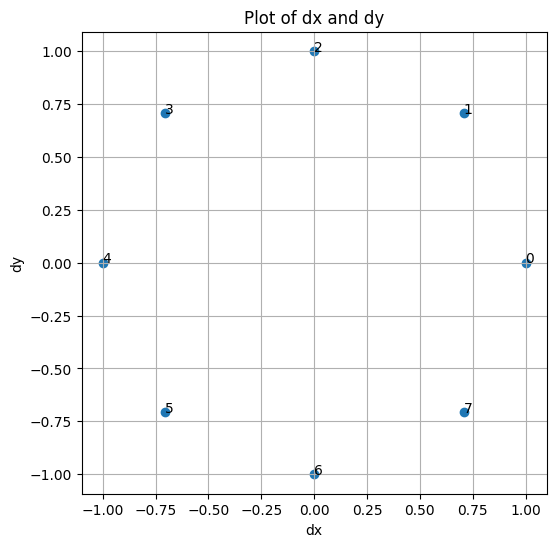

In [ ]:
angulos = 2*np.pi*np.arange(8)/8
dy = 1 * np.sin(angulos)
dx =  1 * np.cos(angulos)

plt.figure(figsize=(6,6))
plt.scatter(dx, dy)
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('Plot of dx and dy')
plt.grid(True)
plt.axis('equal')

# Add labels to each point
for i, (x, y) in enumerate(zip(dx, dy)):
    plt.text(x, y, str(i))

plt.show()

### Test LBP

In [ ]:
def pltLBP(img, nombre, axs, fila):
  lbp = lbp_uniform(img)

  axs[fila][0].imshow(img, cmap='gray')
  axs[fila][0].axis(False)
  axs[fila][0].set_title(nombre)

  axs[fila][1].imshow(lbp, cmap='gray')
  axs[fila][1].axis(False)
  axs[fila][1].set_title(f"LBP: {lbp[1,1]}")


El valor en el titulo deberia Matchear



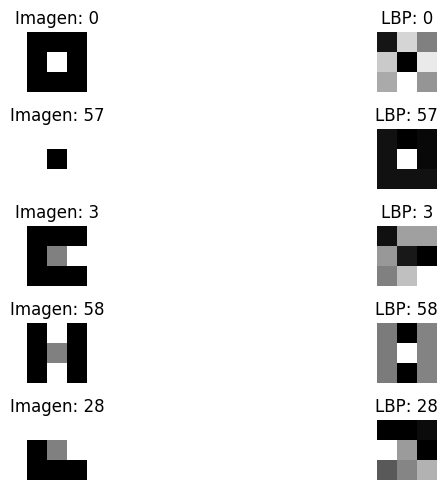

In [ ]:
lbp0 = np.asarray([[0,0,0],[0,255,0],[0,0,0]])
lbp57 = np.asarray([[255,255,255],[255,0,255],[255,255,255]])
lbp3 = np.asarray([[0,0,0],[0,128,255],[0,0,0]])
lbp58 = np.asarray([[0,255,0],[0,128,0],[0,255,0]])
lbp28 = np.asarray([[255,255,255],[0,128,255],[0,0,0]])

print("="*80)
print("El valor en el titulo deberia Matchear")
print("="*80)
print()

fig,axs = plt.subplots(5,2, figsize=(10,5))

pltLBP(lbp0, "Imagen: 0", axs, 0)
pltLBP(lbp57, "Imagen: 57", axs, 1)
pltLBP(lbp3, "Imagen: 3", axs, 2)
pltLBP(lbp58, "Imagen: 58", axs, 3)
pltLBP(lbp28, "Imagen: 28", axs, 4)

plt.tight_layout()
plt.show()

## ***CHECKPOINT 1!***

## **LPB Uniforme para Reconocimiento de Rostros**


Aprobechando que LPB es un descriptor de texturas robusto a los cambios de iluminacion, podemos utilizarlo para crear descriptores unicos de objetos. En este caso lo usaremos para encontrar patrones especificos en rostros, que luego usaremos para identificarlos dentro de otras fotos.

Para esta parte utilizaremos ***AT&T (Olivetti Faces)***, un data set para reconocimiento de rostros.

Este procedimiento se trata de una version mas simplicada del paper: [Face Recognition with Local Binary Patterns](https://link.springer.com/chapter/10.1007/978-3-540-24670-1_36)

### ***Cargamos el Data Set***

Descargando el dataset AT&T (Olivetti Faces)...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Dataset cargado: 400 imágenes de tamaño 64x64


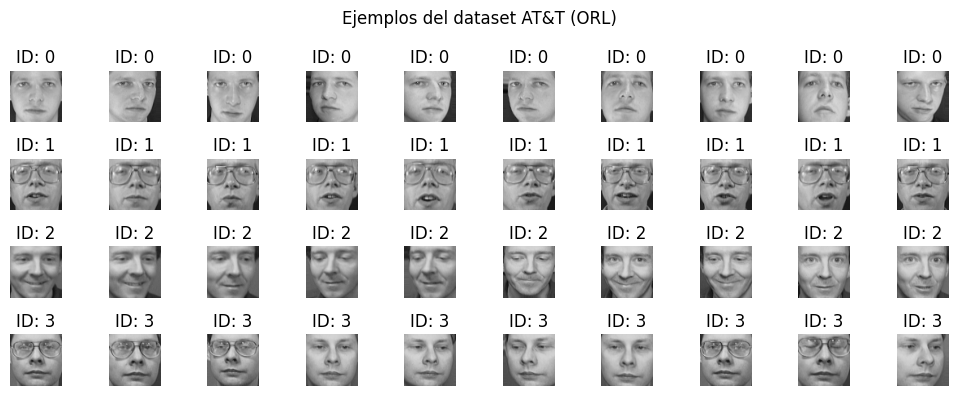

In [ ]:
print("Descargando el dataset AT&T (Olivetti Faces)...")
data = fetch_olivetti_faces()
X = data.images
y = data.target
print(f"Dataset cargado: {X.shape[0]} imágenes de tamaño {X.shape[1]}x{X.shape[2]}")

# Visualizamos algunas caras
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i], cmap='gray', clim=(0,1))
    ax.axis('off')
    ax.set_title(f"ID: {y[i]}")

plt.suptitle('Ejemplos del dataset AT&T (ORL)')
plt.tight_layout()
plt.show()


### ***Comparacion con Scikit Image***

**Importante**: Puede suceder que los bordes sean distintos, estamos usando una tecnica de padding distinta

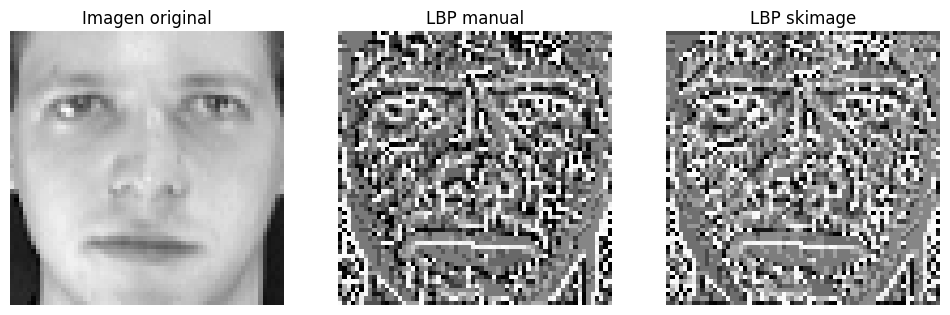

In [ ]:
# Ejemplo visual de LBP manual vs skimage
img = img_as_ubyte(X[0])
lbp_mia = lbp_uniform(img, P=8, R=1)
lbp_ski = local_binary_pattern(img, P=8, R=1, method='nri_uniform')

# Label Numerico mas Grande
max_value = 2 + 8*(8-1) + 1

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img, cmap='gray'); axs[0].set_title('Imagen original'); axs[0].axis('off')
axs[1].imshow(lbp_mia, cmap='gray', clim=(0,max_value)); axs[1].set_title('LBP manual'); axs[1].axis('off')
axs[2].imshow(lbp_ski, cmap='gray', clim=(0,max_value)); axs[2].set_title('LBP skimage'); axs[2].axis('off')
plt.show()

### ***Extraccion de Vector de Caracteristicas***

Una de las formas mas directas para extraer un vector de caracteristicas de una cara seria directamente utilizar su histograma LBP. El problema de este metodo, como de cualquiera que utilice un histograma, es que perderiamos toda informacion espacial sobre las texturas en la cara, ya que todo se mezclaria en la misma districion.

Aun asi, la ***invarianza traslacional*** *(que el descriptor no cambie segun traslaciones del contenido)* que un histograma nos aporta es deseable para un descriptor de images.

Una forma de combinar los dos mundos es dividir la imagen en bloques y crear un histograma LBP para cada uno de ellos, nuestro descriptor final sera la concatenacion de cada uno de ellos en un gran vector de caracteristicas.

![alg](https://www.researchgate.net/publication/323057610/figure/fig3/AS:663171840868354@1535123896222/llustration-of-Local-Binary-Pattern-LBP.png)

In [ ]:
from skimage.transform import resize
## Aplicamos LBP en cada celda de la imagen y creamos su histograma
def lbp_histogram(image, P=8, R=1, grid_x=7, grid_y=7):

    block_width = image.shape[0] // grid_x
    block_height = image.shape[1] // grid_y

    resized_x = block_width * grid_x
    resized_y = block_height * grid_y

    # Transformamos la imagen para que sea del mismo tama;o que el grid.
    image_resized = resize(image, (resized_x, resized_y), anti_aliasing=True)

    # aplicamos LBP
    lbp = lbp_uniform(image_resized, P, R)

    # Por cada bloque conseguimos su histograma
    # y lo utlizamos para construir nuestro descriptor
    blocks = view_as_blocks(lbp, block_shape=(block_width, block_height))
    hist = []
    n_bins = 2 + P*(P-1) + 1

    for i in range(grid_x):
      for j in range(grid_y):
        block = blocks[i, j]
        h, bins = np.histogram(block, bins=np.arange(0, n_bins + 1)) #bins igual no nos interesa
        hist.extend(h)

    return np.array(hist)

In [ ]:
def plot_descriptor(desc,P,grid_x,grid_y):
  fig,axs = plt.subplots(grid_y,grid_x, figsize=(20,10))
  axs = axs.ravel()
  n_bins = 2 + P*(P-1) + 1
  lenght = desc.shape[0]
  index = 0
  for y in range(grid_y):
    for x in range(grid_x):
      start = index * n_bins
      end = start + n_bins

      axs[index].bar(range(n_bins), desc[start:end], width=1, edgecolor="black")
      axs[index].set_title(f"LBP y:{y} x:{x}")

      index += 1

  plt.tight_layout()
  plt.show()


Vector de características: 2891 dimensiones



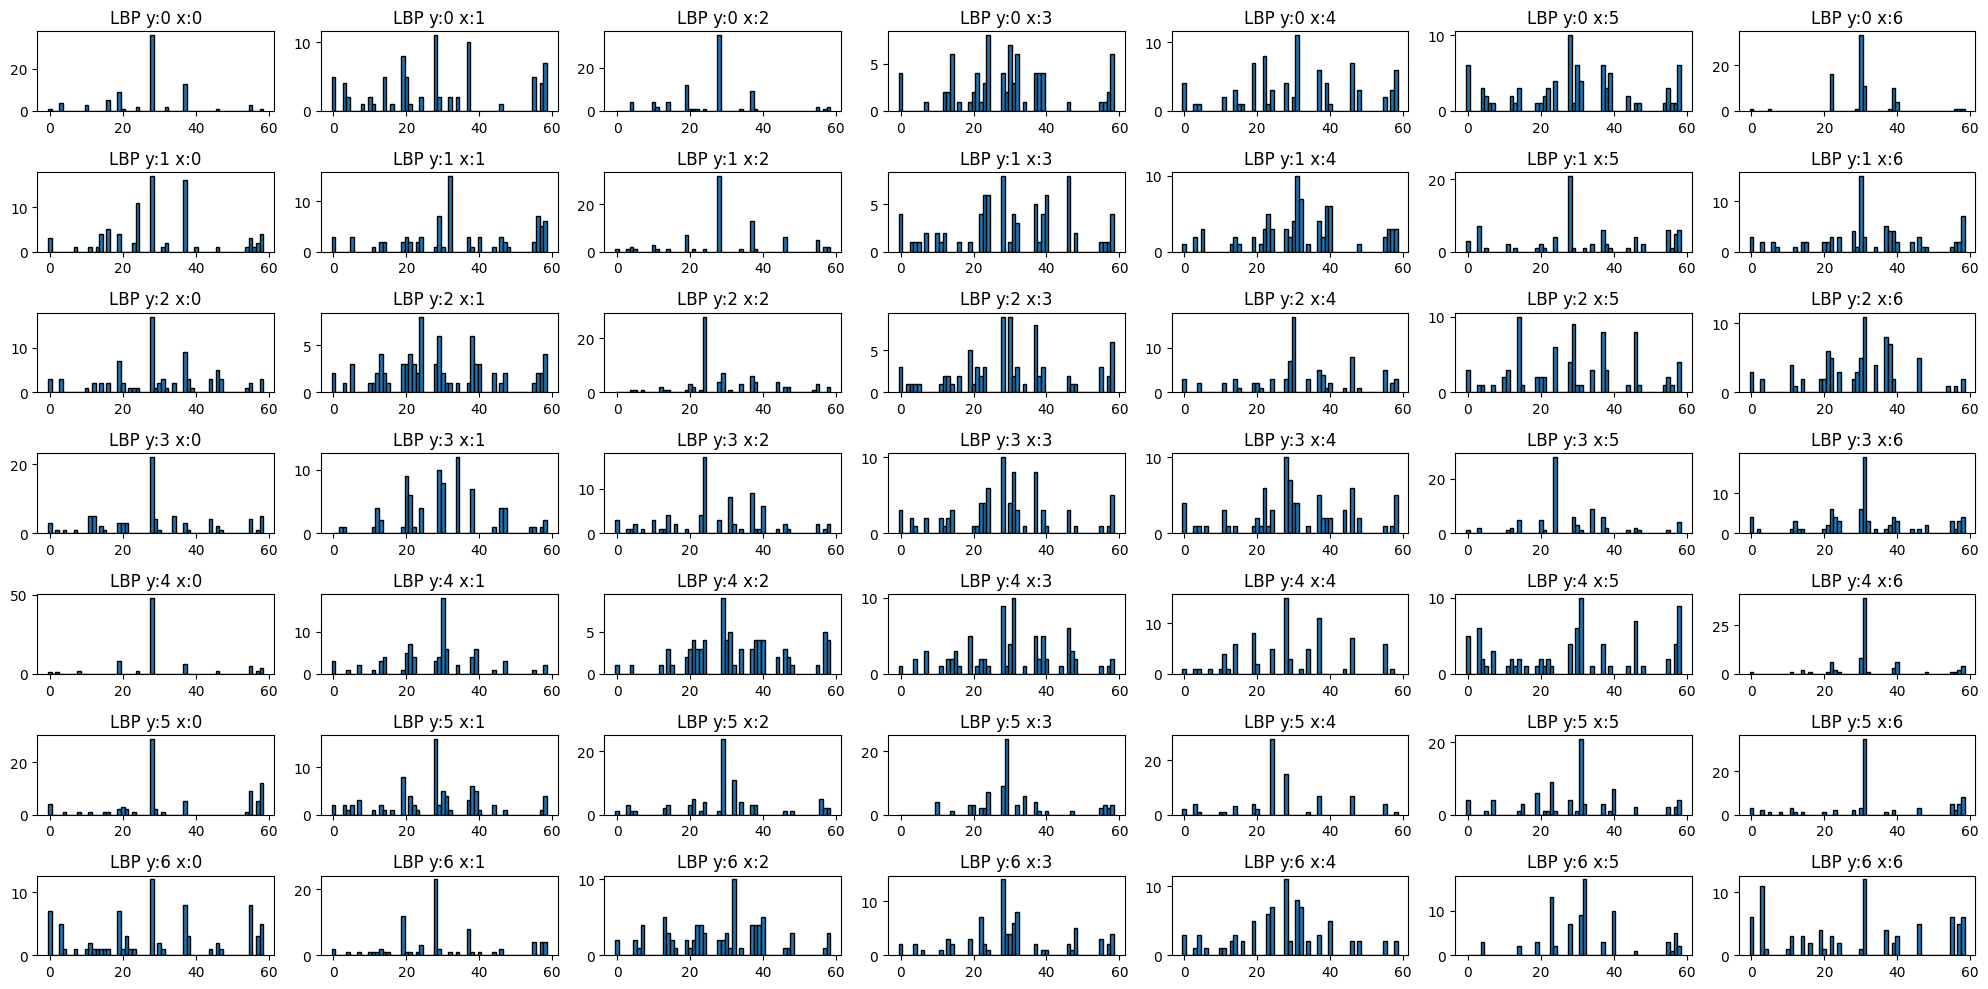

In [ ]:
# Probamos con una imagen
desc = lbp_histogram(X[0], P=8, R=1, grid_x=7, grid_y=7)
print(f"Vector de características: {desc.shape[0]} dimensiones")
print()
plot_descriptor(desc,8,7,7)

### ***Clasificador***

Como clasificador utilizaremos un simple KNeighbors, el cual clasificara nuestro input a la categoria de la mayoria de los K vecinos mas cercanos.

Estos vecinos seran los vectores de caracteristicas dados en el 'entrenamiento' y en donde se conoce su categoria real.

![sadf](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png)


Como distancia utilizaremos $X^2$ segun como lo hace el paper

![](https://media.geeksforgeeks.org/wp-content/uploads/20200323110947/p17-2.jpg)

In [ ]:
# Distancia chi-cuadrado
def chi2_distance(a, b):
    return np.sum(((a - b) ** 2) / (a + b + 1e-10))

class Chi2KNN(KNeighborsClassifier):
    def __init__(self, n_neighbors=1):
        super().__init__(n_neighbors=n_neighbors, metric=chi2_distance)


### ***Entrenamiento del Reconocedor***

Para realizar el entrenamiento primero dividiremos nuestro DataSet en un conjunto de Entrenamiento y otro de Test.

*   El **conjunto de Entrenamiento** lo utilizaremos para entrenar a nuestro clasificador

*   El **conjunto de Test** seran datos nunca vistos por nuestro clasificador y los usaremos para calcular la calidad de sus predicciones.



In [ ]:

# Separamos el dataset en Training y Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

features_train = [lbp_histogram(x) for x in X_train]
features_test = [lbp_histogram(x) for x in X_test]


In [ ]:
print(X.shape)

(400, 64, 64)


In [ ]:
#Entrenamos a nuestro Clasificador
knn = Chi2KNN(n_neighbors=3)
knn.fit(features_train, y_train)

Chi2KNN(n_neighbors=3)

### ***Evaluacion del Clasificador***

**Predicciones**

In [ ]:
y_pred = knn.predict(features_test)
acc = accuracy_score(y_test, y_pred)
print(f"Precisión total: {acc*100:.2f}%")

Precisión total: 95.00%


**Matriz de Confucion**

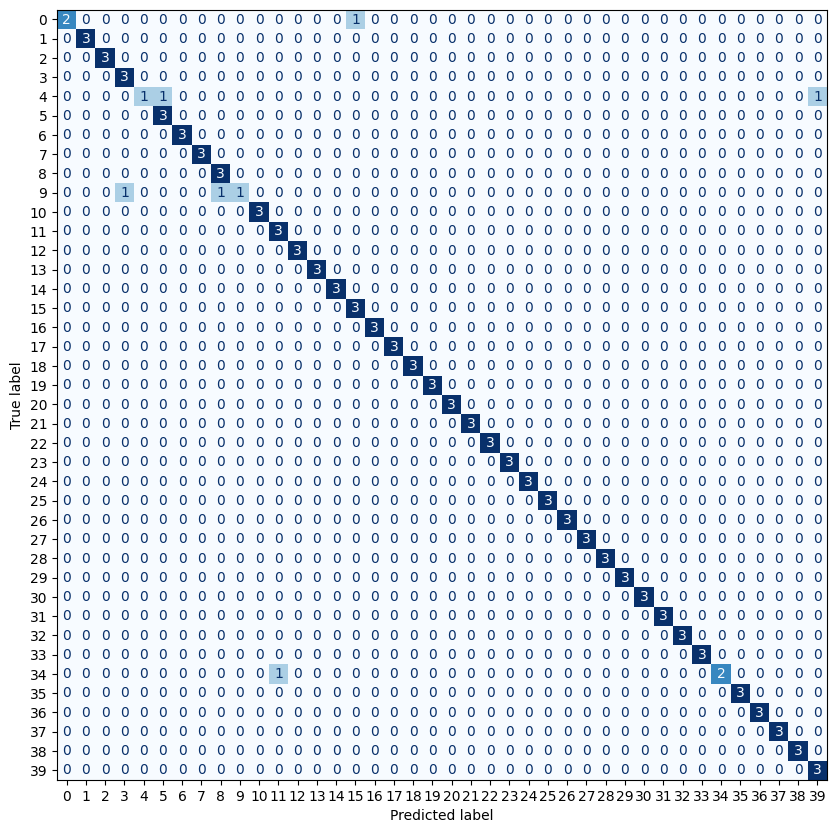

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues', colorbar=False, ax=ax)

plt.show()

**Ejemplos**

Ejemplos Correctos


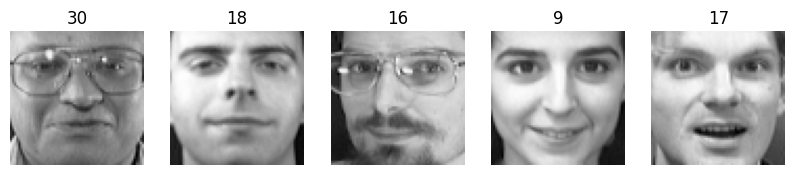


Ejemplos Incorrectos


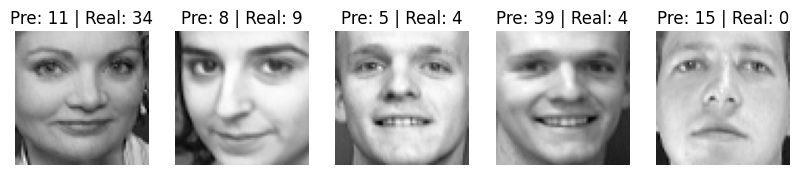

In [ ]:
# Ejemplos correctos/incorrectos
correct_idx = np.where(y_pred == y_test)[0]
wrong_idx = np.where(y_pred != y_test)[0]


print("=" * 80)
print("Ejemplos Correctos")
print("=" * 80)
fig, axs = plt.subplots(1, min(correct_idx.shape[0],5), figsize=(10, 4))
for i, ax in enumerate(axs):
    index = correct_idx[i]
    ax.imshow(X_test[index], cmap='gray')
    ax.set_title(f"{y_pred[index]}")
    ax.axis('off')
plt.show()

print()
print("=" * 80)
print("Ejemplos Incorrectos")
print("=" * 80)
fig, axs = plt.subplots(1, min(wrong_idx.shape[0],5), figsize=(10, 4))
for i, ax in enumerate(axs):
    index = wrong_idx[i]
    ax.imshow(X_test[index], cmap='gray')
    ax.set_title(f"Pre: {y_pred[index]} | Real: {y_test[index]}")
    ax.axis('off')
plt.show()

## ***CHECKPOINT 2!***